In [1]:
from bs4 import BeautifulSoup
import requests
import pandas as pd
from selenium import webdriver
from selenium.webdriver.common.keys import Keys
import time, os
import json

In [98]:
from types import SimpleNamespace

In [99]:
import statistics

In [100]:
import numpy as np

In [101]:
import random
import numpy as np
from sklearn.linear_model import LinearRegression, Lasso, LassoCV, Ridge, RidgeCV
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
import seaborn as sns
sns.set()
import pandas as pd
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import statsmodels.api as sm
import statsmodels.formula.api as smf

from sklearn.pipeline import Pipeline
%matplotlib inline
%pylab inline

Populating the interactive namespace from numpy and matplotlib


/usr/local/anaconda3/lib/python3.8/site-packages/IPython/core/magics/pylab.py:159: UserWarning: pylab import has clobbered these variables: ['random']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


In [102]:
import seaborn as sns



# retrieving data from steamspy api

first attempt at pulling data and transforming it into a dataframe. then can use number of game sales as new target

In [38]:
response = requests.get('http://steamspy.com/api.php?request=all&page=1')

In [101]:
response

<Response [200]>

In [41]:
df = pd.DataFrame(response.json()).T

In [42]:
df.head(1)

,appid,name,developer,publisher,score_rank,positive,negative,userscore,owners,average_forever,average_2weeks,median_forever,median_2weeks,price,initialprice,discount,ccu
240760,240760,Wasteland 2: Director's Cut,inXile Entertainment,inXile Entertainment,,6499,1385,0,"500,000 .. 1,000,000",877,0,681,0,2999,2999,0,32


# Creating loop for all pages
44 pages, will take 44 minutes since I have to include a 60 second wait per API request

In [44]:
for i in range(44):
    response = requests.get(f'http://steamspy.com/api.php?request=all&page={i}')
    list = response.json()
    df = pd.concat([df,(pd.DataFrame(list).T)])
    time.sleep(60)
    
    
    


In [47]:
df.shape

(42773, 17)

In [46]:
df.drop_duplicates(inplace=True)

In [48]:
df.rename(columns={'name':'title'},inplace=True)

In [49]:
df.head(1)

,appid,title,developer,publisher,score_rank,positive,negative,userscore,owners,average_forever,average_2weeks,median_forever,median_2weeks,price,initialprice,discount,ccu
240760,240760,Wasteland 2: Director's Cut,inXile Entertainment,inXile Entertainment,,6499,1385,0,"500,000 .. 1,000,000",877,0,681,0,2999,2999,0,32


# MEDIANATOR
Owners are listed as a range. for modeling, I am creating a quick function to find the median.

In [50]:
def medianator (raw):
    raw2 = (raw.replace(',','').replace('.','').split())
    nums = [int(s) for s in raw2]
    return statistics.median(nums)

In [51]:
df['owners_median'] = df.owners.map(medianator)

In [52]:
df.head()

,appid,title,developer,publisher,score_rank,positive,negative,userscore,owners,average_forever,average_2weeks,median_forever,median_2weeks,price,initialprice,discount,ccu,owners_median
240760,240760,Wasteland 2: Director's Cut,inXile Entertainment,inXile Entertainment,,6499,1385,0,"500,000 .. 1,000,000",877,0,681,0,2999,2999,0,32,750000.0
241540,241540,State of Decay,Undead Labs,Xbox Game Studios,,14963,2744,0,"500,000 .. 1,000,000",1304,0,1461,0,0,0,0,18,750000.0
8800,8800,Civilization IV: Beyond the Sword,Firaxis Games,2K,,2694,100,0,"500,000 .. 1,000,000",3395,196,4337,196,999,999,0,1576,750000.0
70600,70600,Worms Ultimate Mayhem,Team17 Digital Ltd,Team17 Digital Ltd,,3481,471,0,"500,000 .. 1,000,000",213,0,121,0,1499,1499,0,50,750000.0
238260,238260,Pinball Arcade,FarSight Studios,FarSight Studios,,2536,944,0,"500,000 .. 1,000,000",649,0,32,0,0,0,0,42,750000.0


### Saving steamspy's scraped api as steamspy.csv

# Merging StamSpy dataframe with Steam dataframe

In [57]:
df.to_csv(r'/Users/michaelharnett/Desktop/metis\steamspy.csv')

In [60]:
reviewsdf = pd.read_csv('data/reviewsdf.csv')

In [61]:
reviewsdf.shape

(5793, 92)

In [65]:
df.drop(columns = ['appid', 'developer', 'publisher', 'score_rank',
                  'userscore', 'price', 'initialprice', 'discount',
                  'owners'], inplace=True)

In [68]:
reviewsdf.drop(columns=['link', 'release_date', 'review_rating',
                     'num_languages', 'tags', 'genres','publisher',
                     'top_pubs'], inplace=True)

In [224]:
#ownerdf = pd.merge(reviewsdf,df[['title','owners_median','positive','negative']], on=['title'])

In [69]:
ownerdf = pd.merge(reviewsdf,df, on=['title'])

In [70]:
ownerdf.head(1)

,title,been_sale,orig_price,num_reviews,num_tags,num_genres,year_released,languages_filled,rating_val,Singleplayer_tag,...,tinyBuild,positive,negative,owners,average_forever,average_2weeks,median_forever,median_2weeks,ccu,owners_median
0,OUTRIDERS,0,59.99,36837,20.0,3.0,2021,13.0,6,1,...,0,26922,14940,"1,000,000 .. 2,000,000",2074,585,1600,279,23037,1500000.0


In [94]:
ownerdf.columns

Index(['title', 'owners_median', 'positive', 'negative', 'num_reviews',
       'been_sale', 'orig_price', 'num_tags', 'num_genres', 'year_released',
       'languages_filled', 'rating_val', 'Singleplayer_tag', 'Indie_tag',
       'Action_tag', 'Adventure_tag', 'Casual_tag', 'Strategy_tag',
       'Multiplayer_tag', 'RPG_tag', 'Simulation_tag', 'Atmospheric_tag',
       'Horror_tag', '2D_tag', 'Soundtrack_tag', 'Great_tag', 'Story_tag',
       'Rich_tag', 'World_tag', 'Shooter_tag', 'Puzzle_tag', 'TurnBased_tag',
       'Open_tag', 'FirstPerson_tag', 'Survival_tag', 'Fantasy_tag',
       'Funny_tag', 'Coop_tag', 'Platformer_tag', 'Early_tag', 'Access_tag',
       'Sim_tag', 'Indie_genre', 'Action_genre', 'Adventure_genre',
       'Casual_genre', 'Simulation_genre', 'Strategy_genre', 'RPG_genre',
       '_genre', 'Early_genre', 'Access_genre', 'Games_genre', 'Sports_genre',
       'Racing_genre', 'Studios_genre', 'Entertainment_genre',
       'Massively_genre', 'Multiplayer_genre', 'Stud

In [91]:
cols = ownerdf.columns.tolist()

In [92]:
cols.insert(4, cols.pop(cols.index('num_reviews')))

In [93]:
ownerdf = ownerdf[cols]

In [149]:
ownerdf.info()



<class 'pandas.core.frame.DataFrame'>
Int64Index: 5189 entries, 0 to 5188
Data columns (total 92 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   title                       5189 non-null   object 
 1   owners_median               5189 non-null   float64
 2   positive                    5189 non-null   int64  
 3   negative                    5189 non-null   int64  
 4   num_reviews                 5189 non-null   int64  
 5   ccu                         5189 non-null   int64  
 6   median_2weeks               5189 non-null   int64  
 7   median_forever              5189 non-null   int64  
 8   average_2weeks              5189 non-null   int64  
 9   average_forever             5189 non-null   int64  
 10  been_sale                   5189 non-null   int64  
 11  orig_price                  5189 non-null   float64
 12  num_tags                    5189 non-null   float64
 13  num_genres                  5189 

In [112]:
ints_list = ['positive','negative', 'average_forever', 'average_2weeks',
            'median_forever', 'median_2weeks', 'ccu']
for things in ints_list:
    ownerdf[things] = ownerdf[things].astype(int)


In [148]:
bring2front = ['average_forever', 'average_2weeks',
               'median_forever', 'median_2weeks', 'ccu']

cols = ownerdf.columns.tolist()

for items in bring2front:
    cols.insert(5, cols.pop(cols.index(items)))

ownerdf = ownerdf[cols]

# Modeling
using ownership as target


In [150]:
X, y = ownerdf.iloc[:,2:], ownerdf.iloc[:,1]

In [151]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=7)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=7)

In [152]:
lr = LinearRegression()

In [153]:
lr.fit(X_train, y_train)
lr.score(X_train, y_train)

0.8042508113629196

In [154]:
lr.score(X_val, y_val)

0.7627400280940863

In [156]:
train_preds = lr.predict(X_train)

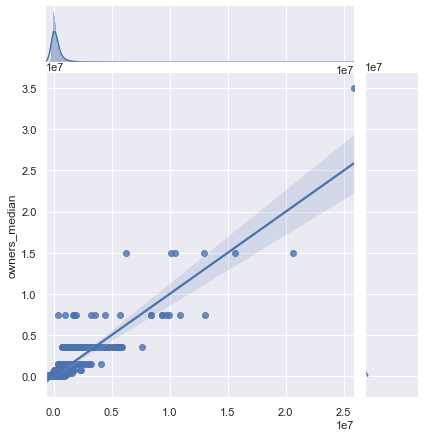

In [157]:
sns.jointplot(x=train_preds,y=y_train, kind='reg')

In [158]:
rmse = mean_squared_error(y_train, train_preds, squared=False)
print(rmse)
mae = mean_absolute_error(y_train, train_preds)
print(mae)

540540.3440522465
221729.19511907827


In [160]:
ownerdf.corr()

,owners_median,positive,negative,num_reviews,ccu,median_2weeks,median_forever,average_2weeks,average_forever,been_sale,...,Electronic Arts,Paradox Interactive,SEGA,Sokpop Collective,Square Enix,THQ Nordic,Ubisoft,Winged Cloud,other,tinyBuild
owners_median,1.000000,0.901520,0.712095,0.899763,0.755281,0.087061,0.065027,0.108491,0.289349,-0.047430,...,0.015933,0.039023,0.016020,-0.018557,0.019136,0.002951,0.015807,-0.012249,-0.042996,0.001988
positive,0.901520,1.000000,0.614339,0.944267,0.714906,0.098773,0.067173,0.132630,0.303426,-0.050414,...,0.004677,0.040404,0.005714,-0.016910,0.003861,-0.006539,0.005969,-0.012946,-0.023070,-0.004318
negative,0.712095,0.614339,1.000000,0.769682,0.915485,0.040239,0.072567,0.058557,0.246623,-0.018396,...,0.001525,0.013237,-0.000381,-0.006290,0.005194,-0.001218,0.001250,-0.004560,-0.011547,-0.001674
num_reviews,0.899763,0.944267,0.769682,1.000000,0.819459,0.086086,0.072660,0.117588,0.304447,-0.045369,...,0.003238,0.034384,0.003899,-0.015010,0.003992,-0.005584,0.004822,-0.011430,-0.019794,-0.004035
ccu,0.755281,0.714906,0.915485,0.819459,1.000000,0.074106,0.091284,0.101015,0.318940,-0.024445,...,0.007390,0.042519,0.028297,-0.007401,0.012508,-0.005133,-0.003356,-0.006259,-0.021765,-0.005270
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
THQ Nordic,0.002951,-0.006539,-0.001218,-0.005584,-0.005133,-0.004153,-0.000608,-0.004743,-0.003819,0.007921,...,-0.006746,-0.007171,-0.007171,-0.007670,-0.007861,1.000000,-0.005134,-0.006524,-0.281035,-0.006855
Ubisoft,0.015807,0.005969,0.001250,0.004822,-0.003356,-0.005264,0.009553,-0.004404,0.011968,-0.024515,...,-0.004574,-0.004862,-0.004862,-0.005200,-0.005330,-0.005134,1.000000,-0.004423,-0.190538,-0.004648
Winged Cloud,-0.012249,-0.012946,-0.004560,-0.011430,-0.006259,-0.008232,-0.009489,-0.008221,-0.014319,0.180420,...,-0.005812,-0.006178,-0.006178,-0.006608,-0.006772,-0.006524,-0.004423,1.000000,-0.242106,-0.005905
other,-0.042996,-0.023070,-0.011547,-0.019794,-0.021765,-0.043192,-0.077995,-0.043328,-0.096451,-0.040721,...,-0.250364,-0.266130,-0.266130,-0.284643,-0.291729,-0.281035,-0.190538,-0.242106,1.000000,-0.254395


In [164]:
X, y = ownerdf.iloc[:,2:15], ownerdf.iloc[:,1]

In [165]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=7)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=7)

In [166]:
lr = LinearRegression()

In [167]:
lr.fit(X_train, y_train)
lr.score(X_train, y_train)

0.7961642648028194

In [168]:
lr.score(X_val, y_val)

0.7612925423117416

<AxesSubplot:>

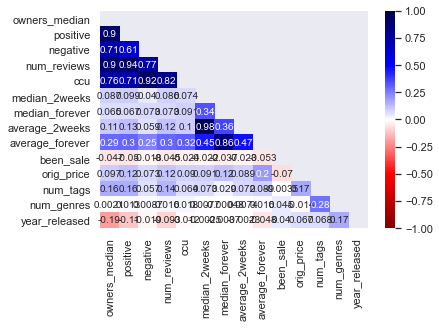

In [170]:
heatmapdf = ownerdf.iloc[:,1:15]
upper = np.triu(heatmapdf.corr())
sns.heatmap(heatmapdf.corr(), cmap="seismic_r", annot=True, vmin=-1, vmax=1, mask=upper)



In [171]:
import scipy.stats as stats

In [172]:
def diagnostic_plot(X, y):
    plt.figure(figsize=(20,5))
    
    rgr = LinearRegression()
    rgr.fit(X,y)
    pred = rgr.predict(X)
    
    plt.subplot(1, 2, 1)
    res = y - pred
    plt.scatter(pred, res)
    plt.title("Residual plot")
    plt.xlabel("prediction")
    plt.ylabel("residuals")
    
    plt.subplot(1, 2, 2)
    #Generates a probability plot of sample data against the quantiles of a 
    # specified theoretical distribution 
    stats.probplot(res, dist="norm", plot=plt)
    plt.title("Normal Q-Q plot")

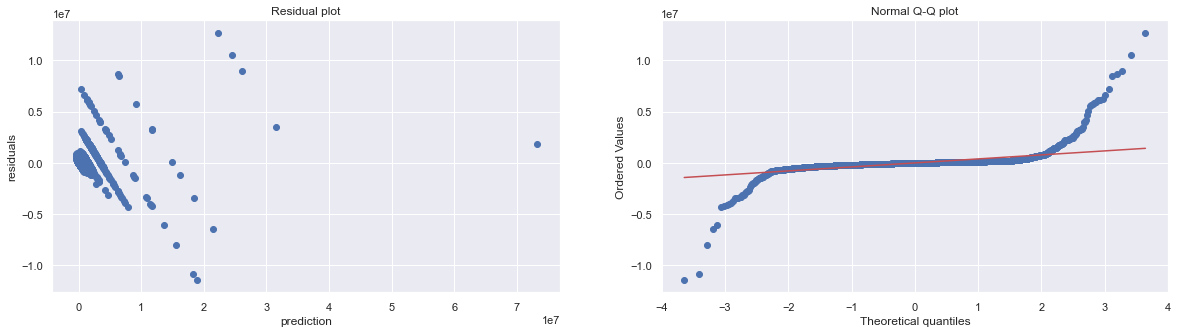

In [173]:
diagnostic_plot(X, y)

In [174]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [175]:
def vif(df_X):
    '''
    Calculate the VIF for each feature of df_X (a Pandas DataFrame).
    '''
    vif_data = [variance_inflation_factor(df_X.values, i)
                for i in range(df_X.shape[1])]
    
    return pd.Series(vif_data, index=df_X.columns)

In [177]:
vif(ownerdf.iloc[:, 2:])

/usr/local/anaconda3/lib/python3.8/site-packages/statsmodels/regression/linear_model.py:1715: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
/usr/local/anaconda3/lib/python3.8/site-packages/statsmodels/stats/outliers_influence.py:193: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


positive         13.945982
negative          8.724745
num_reviews      20.274831
ccu               9.208352
median_2weeks    26.279191
                   ...    
THQ Nordic        2.665985
Ubisoft           1.767111
Winged Cloud      2.312724
other            17.760406
tinyBuild         2.427541
Length: 90, dtype: float64

# Modeling 2
reviews as target

In [180]:
cols = ownerdf.columns.tolist()
cols.insert(1, cols.pop(cols.index('num_reviews')))
reviewsdf2 = ownerdf[cols]

In [189]:
X, y = reviewsdf2.iloc[:,2:], reviewsdf2.iloc[:,1]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=7)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=7)

In [190]:
lr.fit(X_train, y_train)
lr.score(X_train, y_train)

0.851248268660552

In [191]:
lr.score(X_val, y_val)

0.9932032136352896

<AxesSubplot:>

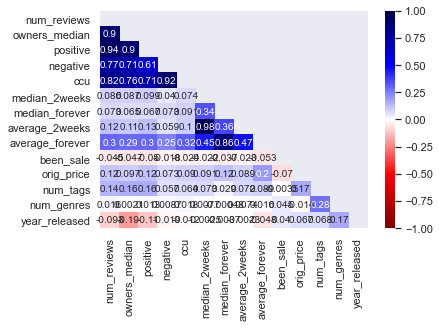

In [192]:
heatmapdf = reviewsdf2.iloc[:,1:15]
upper = np.triu(heatmapdf.corr())
sns.heatmap(heatmapdf.corr(), cmap="seismic_r", annot=True, vmin=-1, vmax=1, mask=upper)


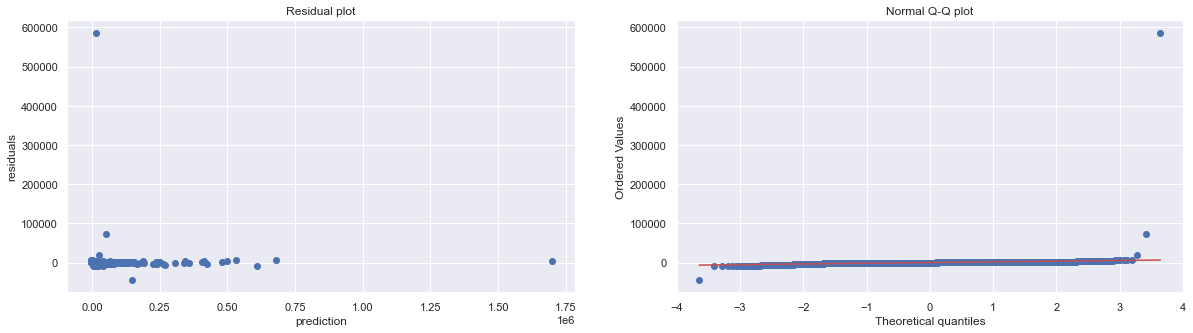

In [193]:
diagnostic_plot(X, y)

In [194]:
vif(reviewsdf2.iloc[:, 2:])

/usr/local/anaconda3/lib/python3.8/site-packages/statsmodels/regression/linear_model.py:1715: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
/usr/local/anaconda3/lib/python3.8/site-packages/statsmodels/stats/outliers_influence.py:193: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


owners_median     7.795690
positive          6.692282
negative          7.540237
ccu               9.224832
median_2weeks    26.530636
                   ...    
THQ Nordic        2.666430
Ubisoft           1.767395
Winged Cloud      2.313029
other            17.766075
tinyBuild         2.427558
Length: 90, dtype: float64